<a href="https://colab.research.google.com/github/pascal-maker/brain-tumor/blob/master/Brain_Tumor_Recognition_using_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


100%|██████████| 15.1M/15.1M [00:00<00:00, 41.1MB/s]

Extracting files...


Data source import complete.


# PART 1 - OpenCV

In [1]:
import os
import cv2

import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
tumour_images=[]
for name in glob.glob('/content/brain-mri-dataset/brain_tumor_dataset/yes/Y104.jpg'):
    image = cv2.imread(name)
    image = cv2.resize(image,(240,240))
    tumour_images.append(image)

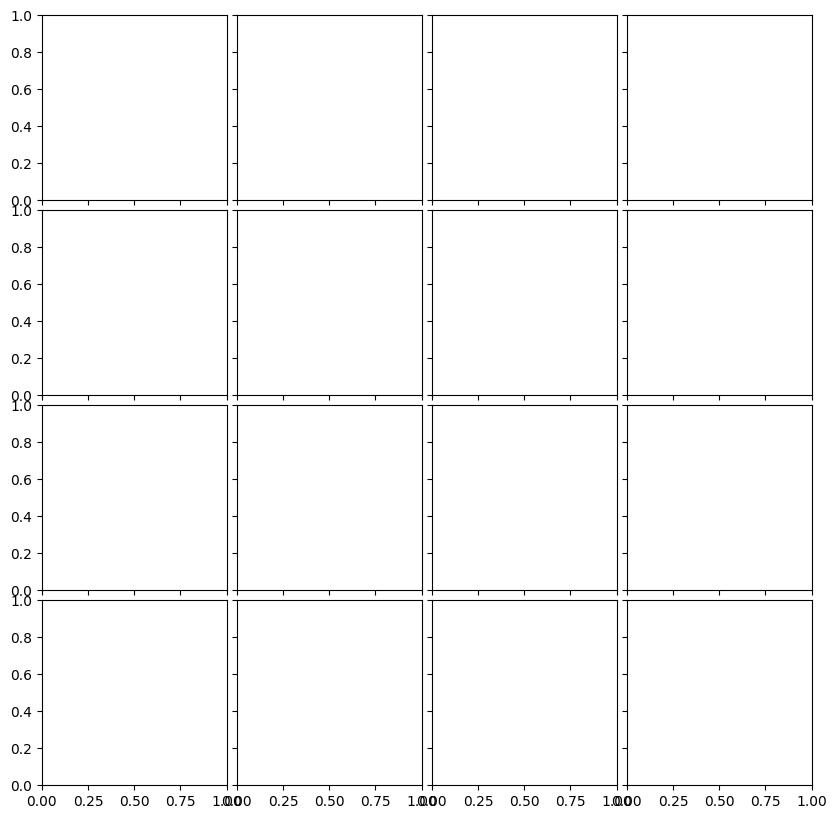

In [3]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),  axes_pad=0.1,   )
for ax, im in zip(grid, tumour_images[0:16]):
    ax.imshow(im)
plt.show()

In [4]:
img_path = "/content/brain-mri-dataset/brain_tumor_dataset/yes/Y104.jpg"
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(500,590)
image=cv2.resize(image, dim)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

print("Path to dataset files:", path)

In [ ]:
import kagglehub
import shutil

# Download to the default path
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")

# Move dataset to /content
new_path = "/content/brain-mri-dataset"
shutil.move(path, new_path)

print("Path to dataset files:", new_path)


In [ ]:
plt.imshow(image)

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(image)


In [ ]:
(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)


In [ ]:
(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshInv)


In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed)

In [ ]:
closed = cv2.erode(closed, None, iterations = 19)
closed = cv2.dilate(closed, None, iterations = 17)

In [ ]:
plt.imshow(closed)

In [ ]:
ret,mask = cv2.threshold(closed, 155, 255, cv2.THRESH_BINARY)
#apply AND operation on image and mask generated by thrresholding
final = cv2.bitwise_and(image,image,mask = mask)
plt.imshow(final)

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged
canny = auto_canny(closed)
plt.imshow(canny)

In [ ]:
(cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL,
cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
plt.imshow(image)

# Part 2 - FastAI

In [29]:
import numpy as np
import pandas as pd
import os,gc,pathlib
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
print(os.listdir("/content/brain-mri-dataset"))
import torchvision.models as models

['yes', 'no', 'brain_tumor_dataset']


In [30]:
DATA_DIR='/content/brain-mri-dataset'

In [31]:
os.listdir(f'{DATA_DIR}')

['yes', 'no', 'brain_tumor_dataset']

In [39]:
# Import necessary libraries from Fastai
from fastai.vision.all import *
import os

# Define your data directory path
DATA_DIR = '/content/brain-mri-dataset'

# Verify the contents of DATA_DIR
print("Files in DATA_DIR:", os.listdir(DATA_DIR))

# Set up ImageDataLoaders using the updated Fastai method
data = ImageDataLoaders.from_folder(
    DATA_DIR,                # Path to the data directory
    valid_pct=0.25,          # Use 25% of data for validation
    item_tfms=Resize(224),   # Resize images to 224x224
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True), # Data augmentation
    bs=24                    # Batch size
)

# Check the classes to confirm setup
print(f'Classes: {data.vocab}')


Files in DATA_DIR: ['yes', 'no', 'brain_tumor_dataset']
Classes: ['no', 'yes']


In [34]:
!pip install fastai --upgrade




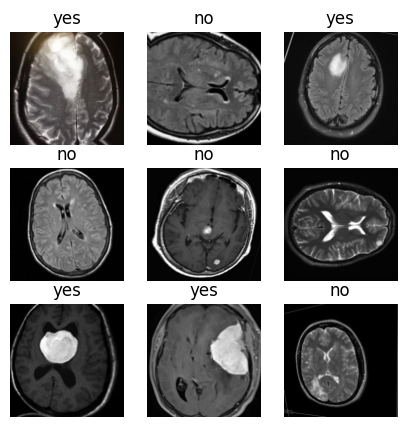

In [41]:
data.show_batch( figsize=(5,5))

In [45]:
from fastai.vision.all import *

# Assuming data has been defined with ImageDataLoaders.from_folder
learner = cnn_learner(
    data,
    vgg16,                         # Use vgg16 architecture
    metrics=[accuracy],            # Metrics to evaluate during training
    cbs=[ShowGraphCallback()],     # Callback to show training graphs
    model_dir="/tmp/model/"        # Directory to save the model
)


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██

AttributeError: 'Sequential' object has no attribute 'plot_lr_find'

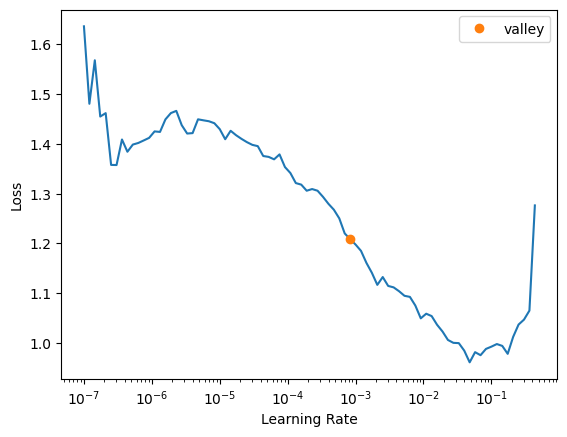

In [47]:
learner.lr_find()
learner.plot_lr_find()  # This replaces learner.recorder.plot()


In [49]:
learner.fit_one_cycle(15, lr=slice(1e-2))


TypeError: Learner.fit_one_cycle() got an unexpected keyword argument 'lr'

In [50]:
learner.save('/kaggle/working/model_1')

RuntimeError: Parent directory /kaggle/working does not exist.

In [51]:
learner.unfreeze()

In [ ]:
learner.lr_find()
learner.recorder.plot()

In [ ]:
learner.load('/kaggle/working/model_1')

In [ ]:
learner.fit_one_cycle(15, max_lr=slice(1e-05))

In [ ]:
learner.save('/kaggle/working/stage_2_1')

In [ ]:
learner.fit_one_cycle(15, max_lr=slice(1e-06))

In [ ]:
learner.save('/kaggle/working/stage_2_2')

In [ ]:
learner.fit_one_cycle(15, max_lr=slice(1e-04))

In [ ]:
learner.save('/kaggle/working/stage_2_3')

In [ ]:
learner.recorder.plot_losses()

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_top_losses(12, figsize=(10,10))

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)